# Problem Statement
Performing an efficient management of budget and securing accuracy are key points when using crowdsourcing. In classification scenarios the crowd sometimes can be noisy and generate a lack of concensus over tasks. The majority of the state-of-art approaches set a fixed number of votes per item and aggregate the votes with some criteria, this produces a reduction in the quality and an increment of costs. For this reason we present a smart detection algorithm which predicts the best decision between stop or continue collecting votes over a task and analyze its efficiency with different experiments.

Formalizing the problem, given a set of items $I$, a set of votes $V$, a classification function $fn$, a classification threshold $th$ and a cost ratio for crowd to expert vote cost $cr$, for each item we want to find the minimum amount of votes needed to take the decision of continue collecting votes or switch to an expert vote. For this we describe a smart stopping algorithm. 

**We define a 3 methods structure**:
- the **classifier** which returns the probability of an item being classified
- the **cost estimator** which returns the estimated cost for each item given the votes
- the **decision function** which returns a boolean decision for each item

# Rationale for the algorithms

### Classifier function

- Input: item votes
- Output: probability IN [0, 1]

### Cost estimator function


- Input: item votes, classification threshold, classification function, cost ratio
- Output: predicted cost
- Logic:
    - Iterate N times for converging the results
        - Calculate actual cost for the given votes
        - While (is not classified or is not too expensive)
            - If actual cost is not too expensive
                - Get P(IN) using the classification function
                - If P(IN) > threshold or P(OUT) > threshold
                    - **Stop because item is classified**
                - Else
                    - Simulate 1 vote over the item using P(IN)
                    - Increment actual cost
            - Else **stop because the item is too expensive to be classified**

### Decision function



- Input: items, votes, classification_threshold, cost_ratio, classification_function
- Output: Boolean decision over each item, where True = continue and False = stop collecting votes
- Logic:
    - For each item
        - Get P(IN) using the classification function
        - If P(IN) > classification threshold or P(OUT) > classification threshold
            - Decision over item = False
        - Else
            - Call **cost estimator function**
                - If cost estimated <= max cost
                    - Decision over item = True
                - Else
                    - Decision over item = False


### Item Classification without expert vote

* The logic for item classification once votes are collected is defined as:
    * P(i = OUT|item_votes) = 1 - classifier_function(item_votes)
    * If P(i = OUT|item_votes) > classification_threshold -> item is classified as OUT **else** is classified as IN
    
    
    
- This can be interpreted as if there isn't enough evidence(votes) to classify the item OUT, is classified IN. This directly affects the Recall metric due to the false positives.

# Experiments

Here we discuss a few experiments, the objective is to compare the overall crowdsourcing cost and quality in the case where we have a smart stopping algorithm vs 
- the baseline approach where all items receive the same amount of votes
- an approach introduced by Andrew W. Brown and David B. Allison. 2014. Using Crowdsourcing to Evaluate Published Scientific Literature: Methods and Example. Plos One 9, 7 (2014). Where 2 votes are requested and if they disagree ask a third to break the tie

In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from helpers.mv_single_binary import majority_voting
from helpers.truth_finder_single import truth_finder_single as truth_finder
import helpers.algorithms_utils as alg_utils
from IPython.display import HTML
import matplotlib.pyplot as plt

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Hyperparameters for all experiments

In [2]:
#main
cf = majority_voting
cr = .05
base_votes_per_item = 3

#cost estimator
drawing_simulations_amount = 50
expert_cost_increment = 2

#crowd
workers_num = 1000 #fixed number
z = 0 #% cheaters
base_workers_acc = .5
fixed_acc = False
fixed_workers_acc = .9


#ground truth 
items_num = 1000
data_true_percentage = .5

#experiment 
iterations_per_ct = 50
cts = [.5, .6, .7, .8, .9] #classification thresholds

#loss ratio: false negative increment penalization
lr = 5 #1 means not penalization

In [3]:
columns = ["Cost mean","Cost Std", "TC mean", "TC std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]
pdColumns = ["Threshold"] + columns

## 1) Experiments without considering workers accuracy for predictions

## 1.1) Smart stop with MV as classification function, where the Expected cost is limited by expert cost.

## 1.1.1) Logic

1. Evalute for each classification threshold
2. Iterate N times per threshold for converging results doing:
    1. Generate workers accuracy
    2. Generate ground truth values
    3. Generate the base votes for each item
    4. Call the decision function
        1. If we have any item to continue collecting votes:
            1. Collect 1 more vote per item
            2. Call decision function
    5. Classify items using MV
        1. If P(OUT) > threshold, classify it as OUT
        2. Else classify it as IN
    6. Calculate the metrics

In [4]:
'''
    Input:
        v - votes for item i
        ct - value between 0 and 1 for deciding if prob of data is enough or must continue
        cf - function to calculate how likely is to be classified
        cr - cost ratio between crowd to expert vote [0,1]
    Output:
        (cost_mean, cost_std)
'''
def cost_estimator(v, ct, cf, cr):
    simulated_costs = []
    
    for _ in range(drawing_simulations_amount):
        must_continue = True
        i_item_votes = v.copy()
        while (must_continue):
            classification_prob_in = cf(alg_utils.input_adapter_single(i_item_votes))
            classification_prob_out = 1 - classification_prob_in
            if ((classification_prob_in > ct) or (classification_prob_out > ct)):
                must_continue = False            
                simulated_costs.append(alg_utils.get_crowd_cost(i_item_votes, cr))
            else:
                vote = np.random.binomial(1, classification_prob_in)
                new_index = max(i_item_votes.keys()) + 1
                i_item_votes[new_index] = [vote]
                actual_cost = alg_utils.get_crowd_cost(i_item_votes, cr)
                
                if((actual_cost) >= (1 * expert_cost_increment)):
                    must_continue = False
                    simulated_costs.append(actual_cost)
        #end while      
    #end for
                    
    return (np.mean(simulated_costs),np.std(simulated_costs))

In [5]:
'''
Function to answer: must continue collecting votes over each task?

Input:
items - set of items
votes - set of votes over each item
classification_threshold - value between 0 and 1 for deciding if prob of data is enough or must continue
cost_ratio - ratio of crowd to expert cost, [0,1]
classification_function - function to calculate how likely is to be classified

Output:
    Dictionary with the decision indexed by item_id
        {
            item_id: bool
            ...
            item_n: ...
        }
    Where False = Stop and True=Continue collecting votes
'''
def decision_function(items, votes, ct, cr, cf):       
    results = {i:(((1 - ct) <= cf(alg_utils.input_adapter_single(i_votes)) <= ct)) for i, i_votes in votes.items()}
    
    ids_items_unclassified = [i for i, d in results.items() if d == True]
    #th_items_n = 100
    
    for item_id in ids_items_unclassified:
        item_votes = votes[item_id].copy()
        cost_mean, cost_std = cost_estimator(item_votes, ct, cf, cr)

        if(cost_mean > (1 + (alg_utils.get_crowd_cost(item_votes, cr)))):
            results[item_id] = False
    
    return results

In [6]:
def generate_votes_1(params, items_num, ct, gt):
    total_votes = {}
    
    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(params['votes_per_item']):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]
            
    #evaluate votes
    results = decision_function(items_num, total_votes, ct, params['cost_ratio'], 
                                                   params['classification_fn'])
    
    #Check if must continue collecting votes
    items_predicted_classified = alg_utils.get_items_predicted_classified(results)
    must_get_more_votes = len(items_predicted_classified) > 0
     
    while(must_get_more_votes):
        total_votes_aux = {}
        for i, v in items_predicted_classified.items():           
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)
            
            total_votes[i][worker_id] = [vote]
            
            total_votes_aux[i] = total_votes[i]
        #end for
        results = decision_function(len(total_votes_aux), total_votes_aux, ct, params['cost_ratio'], 
                                                   params['classification_fn'])

        #Stop when there are no more items that can be classified
        items_predicted_classified = alg_utils.get_items_predicted_classified(results)
        must_get_more_votes = len(items_predicted_classified) > 0
    #end while
    
    items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)

    return [items_classification, total_votes]

In [7]:
def run_experiment_1():
    main_results = []

    print(f'Running Experiment 1: Smart Stop {cf.__name__}')
    alg_utils.print_hyperparameters(cf, cr, base_votes_per_item, drawing_simulations_amount, expert_cost_increment, workers_num, z, fixed_acc, base_workers_acc, fixed_workers_acc, items_num, data_true_percentage, iterations_per_ct, cts, lr)
    
    for ct in tqdm(cts):
        ct = round(ct, 2) #limit to two decimals
        crowd_cost = []
        total_cost = []
        items_classified_in = []
        items_classified_out = []
        ct_loss = []
        ct_recall = []
        ct_precision = []
        ct_classified_amount = []
        ct_unclassified_amount = []

        for _ in range(iterations_per_ct):
            workers_accuracy = alg_utils.simulate_workers(workers_num, z, fixed_acc, fixed_workers_acc, base_workers_acc)
            
            params = {
                'workers_accuracy': workers_accuracy,
                'workers_num': workers_num,
                'items_num': items_num,
                'cost_ratio': cr,
                'votes_per_item': base_votes_per_item,
                'classification_fn': cf
            }
            
            ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)
    
            ct_i_results = generate_votes_1(params, items_num, ct, ground_truth)

            items_classification = ct_i_results[0]
            total_votes = ct_i_results[1]
            
            classified_amount, unclassified_amount, ct_i_crowd_cost, ct_i_total_cost = alg_utils.get_total_cost(total_votes, cr, cf, ct, False)
            
            ct_classified_amount.append(classified_amount)
            ct_unclassified_amount.append(unclassified_amount)
            crowd_cost.append(ct_i_crowd_cost)
            total_cost.append(ct_i_total_cost)

            loss,  recall, precision = alg_utils.Metrics.compute_metrics(items_classification, ground_truth, lr)
            ct_loss.append(loss)
            ct_recall.append(recall)
            ct_precision.append(precision)
        #end for iterations

        main_results.append(
            [ct, 
             round(np.mean(crowd_cost), 3), 
             round(np.std(crowd_cost), 3),
             round(np.mean(total_cost), 3),
             round(np.std(total_cost), 3),
             round(np.mean(ct_loss), 3),
             round(np.std(ct_loss), 3),
             round(np.mean(ct_recall), 3),
             round(np.std(ct_recall), 3),
             round(np.mean(ct_precision), 3),
             round(np.std(ct_precision), 3)
            ])
    #end for thresholds

    return main_results

## 1.2) MV with fixed number of votes per item

In this experiment we use the baseline approach of majority voting with a fixed number of votes per item and a classification threshold of .5

## 1.2.1) Logic

1. Iterate N times for converging results where:
    1. Generate workers accuracy
    2. Generate ground truth values
    3. Generate a fixed number of votes for each item
    4. Classify items using MV
    5. Calculate the metrics

In [8]:
def generate_votes_2(params, items_num, ct, gt):
    total_votes = {}

    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(params['votes_per_item']):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]

    items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)
    
    return [items_classification, total_votes]

In [9]:
def run_experiment_2():
    main_results = []
    
    print('Running Experiment 2: MV Baseline')
    alg_utils.print_hyperparameters(cf, cr, base_votes_per_item, drawing_simulations_amount, expert_cost_increment, workers_num, z, fixed_acc, base_workers_acc, fixed_workers_acc, items_num, data_true_percentage, iterations_per_ct, cts, lr)

    for ct in tqdm(cts):
        ct = round(ct, 2) #limit to two decimals
        crowd_cost = []
        total_cost = []
        items_classified_in = []
        items_classified_out = []
        ct_loss = []
        ct_recall = []
        ct_precision = []
        ct_classified_amount = []
        ct_unclassified_amount = []

        for _ in range(iterations_per_ct):
            workers_accuracy = alg_utils.simulate_workers(workers_num, z, fixed_acc, fixed_workers_acc, base_workers_acc)
            
            params = {
                'workers_accuracy': workers_accuracy,
                'workers_num': workers_num,
                'items_num': items_num,
                'cost_ratio': cr,
                'votes_per_item': base_votes_per_item,
                'classification_fn': cf
            }
                
            ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)

            ct_i_results = generate_votes_2(params, items_num, ct, ground_truth)

            items_classification = ct_i_results[0]
            total_votes = ct_i_results[1]

            loss,  recall, precision = alg_utils.Metrics.compute_metrics(items_classification, ground_truth, lr)
            ct_loss.append(loss)
            ct_recall.append(recall)
            ct_precision.append(precision)
            
            ct_i_crowd_cost = sum([len(v) for i, v in total_votes.items()]) * cr
            ct_i_total_cost = ct_i_crowd_cost
       
            crowd_cost.append(ct_i_crowd_cost)
            total_cost.append(ct_i_total_cost)
        #end for iterations
        
        main_results.append(
            [ct,
             round(np.mean(crowd_cost), 3), 
             round(np.std(crowd_cost), 3),
             round(np.mean(total_cost), 3),
             round(np.std(total_cost), 3),
             round(np.mean(ct_loss), 3),
             round(np.std(ct_loss), 3),
             round(np.mean(ct_recall), 3),
             round(np.std(ct_recall), 3),
             round(np.mean(ct_precision), 3),
             round(np.std(ct_precision), 3)
            ])
    #end for thresholds

    return main_results

## 1.3) Two votes first and if disagree one more to break the tie

In this experiment we collect 2 votes per item and a third one if they disagree.

## 1.3.1) Logic

1. Iterate N times for converging results where:
    1. Generate workers accuracy
    2. Generate ground truth values
    3. Generate 2 votes for each item
    4. Evalutes the votes:
        1. If votes agree:
            1. Jump to next step
        2. If votes disagree:
            1. Get 1 more vote 
    4. Classify items using MV
    5. Calculate the metrics

In [10]:
def generate_votes_3(params, items_num, ct, gt):
    total_votes = {}

    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(2):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]
            
        #if disagree get 1 more vote
        votes_disagree = sum([v[0] for i,v in total_votes[i].items()]) == 1
        if(votes_disagree):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]

    items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)
    
    return [items_classification, total_votes]

In [11]:
def run_experiment_3():
    main_results = []
    
    print('Running Experiment 3: MV Brown&Allison')
    alg_utils.print_hyperparameters(cf, cr, base_votes_per_item, drawing_simulations_amount, expert_cost_increment, workers_num, z, fixed_acc, base_workers_acc, fixed_workers_acc, items_num, data_true_percentage, iterations_per_ct, cts, lr)

    for ct in tqdm(cts):
        ct = round(ct, 2) #limit to two decimals
        crowd_cost = []
        total_cost = []
        items_classified_in = []
        items_classified_out = []
        ct_loss = []
        ct_recall = []
        ct_precision = []
        ct_classified_amount = []
        ct_unclassified_amount = []

        for _ in range(iterations_per_ct):
            workers_accuracy = alg_utils.simulate_workers(workers_num, z, fixed_acc, fixed_workers_acc, base_workers_acc)
            
            params = {
                'workers_accuracy': workers_accuracy,
                'workers_num': workers_num,
                'items_num': items_num,
                'cost_ratio': cr,
                'votes_per_item': base_votes_per_item,
                'classification_fn': cf
            }
                
            ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)

            ct_i_results = generate_votes_3(params, items_num, ct, ground_truth)

            items_classification = ct_i_results[0]
            total_votes = ct_i_results[1]

            loss,  recall, precision = alg_utils.Metrics.compute_metrics(items_classification, ground_truth, lr)
            ct_loss.append(loss)
            ct_recall.append(recall)
            ct_precision.append(precision)
            
            ct_i_crowd_cost = sum([len(v) for i, v in total_votes.items()]) * cr
            ct_i_total_cost = ct_i_crowd_cost
       
            crowd_cost.append(ct_i_crowd_cost)
            total_cost.append(ct_i_total_cost)
        #end for iterations
        
        main_results.append(
            [ct,
             round(np.mean(crowd_cost), 3), 
             round(np.std(crowd_cost), 3),
             round(np.mean(total_cost), 3),
             round(np.std(total_cost), 3),
             round(np.mean(ct_loss), 3),
             round(np.std(ct_loss), 3),
             round(np.mean(ct_recall), 3),
             round(np.std(ct_recall), 3),
             round(np.mean(ct_precision), 3),
             round(np.std(ct_precision), 3)
            ])
    #end for thresholds

    return main_results

# 3.3) Results evaluation

## Balanced data

## 3.3.1) Evaluation between mv smart, mv baseline and Brown&Allison


In [86]:
'''
mv_base_01 = pd.read_csv('./results/it10_d10_b5/baseline_mv_it10_v3_b5_cr01.csv')
ba_01 = pd.read_csv('./results/it10_d10_b5/mv_break_tie_it10_b5_cr01.csv')
mv_01 = pd.read_csv('./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr01.csv')
mv_02 = pd.read_csv('./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr02.csv')
mv_03 = pd.read_csv('./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr03.csv')
mv_04 = pd.read_csv('./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr04.csv')
mv_05 = pd.read_csv('./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr05.csv')
mv_06 = pd.read_csv('./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr06.csv')
mv_07 = pd.read_csv('./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr07.csv')
mv_08 = pd.read_csv('./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr08.csv')
mv_09 = pd.read_csv('./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr09.csv')
mv_1 = pd.read_csv('./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr1.csv')


print_columns = ["Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]
cost_mean = "Cost mean"

alg_utils.plot_results(cts, 
                       "Threshold",
                       {
                           "B&A.01": ba_01,
                           "MVBase.01": mv_base_01,
                           "SMV.01": mv_01,
                       },
                       [cost_mean])
    
alg_utils.plot_results(cts, 
                       "Threshold",
                       {
                           "B&A.01": ba_01,
                           "MVBase.01": mv_base_01,
                           "SMV.01": mv_01,
                           "SMV.02": mv_02,
                           "SMV.03": mv_03,
                           "SMV.04": mv_04,
                           "SMV.05": mv_05,
                           "SMV.06": mv_06,
                           "SMV.07": mv_07,
                           "SMV.08": mv_08,
                           "SMV.09": mv_09,
                           "SMV.1": mv_1,
                        },
                        print_columns)
                        
'''

'\nmv_base_01 = pd.read_csv(\'./results/it10_d10_b5/baseline_mv_it10_v3_b5_cr01.csv\')\nba_01 = pd.read_csv(\'./results/it10_d10_b5/mv_break_tie_it10_b5_cr01.csv\')\nmv_01 = pd.read_csv(\'./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr01.csv\')\nmv_02 = pd.read_csv(\'./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr02.csv\')\nmv_03 = pd.read_csv(\'./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr03.csv\')\nmv_04 = pd.read_csv(\'./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr04.csv\')\nmv_05 = pd.read_csv(\'./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr05.csv\')\nmv_06 = pd.read_csv(\'./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr06.csv\')\nmv_07 = pd.read_csv(\'./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr07.csv\')\nmv_08 = pd.read_csv(\'./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr08.csv\')\nmv_09 = pd.read_csv(\'./results/it10_d10_b5/smart_stop_mv_not_expert_i10_d10_b5_cr09.csv\'

In the plots we can see that the loss increments with the cost ratio, this is directly related with the relation between the cost ratio and the number of predicted cost drawings. When the cost is higher it reduces the amount of crowd votes that can be collected, this makes the algorithm take the decision of stop collecting votes in more cases. This increments the false positive number which affects the precision.

##  Analysis over different classification thresholds with fixed expert cost

### Smart stop over different expert costs

The expert cost has a direct impact in the experiments overall cost, in particular for our approach the expert cost sets a limit for the amount of drawings we do for simulate votes. A lower expert cost means a lower cost ratio between crowd to expert cost, and this is translated in the amount of crowd votes we can collect until reaching the expert.  This is one of the key points in our analysis and this is to choose the best alternative between collecting more votes or not to be more confident for taking a decision for classifying an item. 


To observe how the expert cost impact in the performance we set different costs: 10, 50, 100 and 500. To clarify the notion this can be read easily as a relation, if our expert cost is 10 and the crowd cost is 1 we have to collect 10 crowd votes to reach the expert cost, and can be seen as a ratio 1:10.

to-do clarify:
Expert cost -> # crowd votes -> prob -> classification threshold


In [ ]:
smv_05 = pd.read_csv('./results/it50_d50_b5_lr5/smart_stop_mv_not_expert_i50_d50_b5_cr05.csv')
datasets = [
    pd.read_csv('./results/it50_d50_b5_lr5/smart_stop_mv_not_expert_i10_d10_b5_cr02.csv'),
    pd.read_csv('./results/it50_d50_b5_lr5/smart_stop_mv_not_expert_i10_d10_b5_cr04.csv'),
    pd.read_csv('./results/it50_d50_b5_lr5/smart_stop_mv_not_expert_i10_d10_b5_cr06.csv'),
    pd.read_csv('./results/it50_d50_b5_lr5/smart_stop_mv_not_expert_i10_d10_b5_cr08.csv'),
    pd.read_csv('./results/it50_d50_b5_lr5/smart_stop_mv_not_expert_i10_d10_b5_cr1.csv')
]

crs = [.02, .04, .06, .08, .1]
loss_mean_7 = []
loss_mean_8 = []
loss_std_7 = []
loss_std_8 = []
i = 0
for _ in range(len(datasets)):
    #loss_mean_7.append(datasets[i]["Loss mean"][2])
    loss_mean_8.append(datasets[i]["Loss mean"][3])
    #loss_std_7.append(datasets[i]["Loss Std"][2])
    loss_std_8.append(datasets[i]["Loss Std"][3])
    i += 1

    
alg_utils.plot_results(crs, 
                       "Cost ratio",
                       {
                           "ct = .8": {"Loss": loss_mean_8}
                       },
                       ["Loss"])

alg_utils.plot_results(crs, 
                       "Cost ratio",
                       {
                           "ct = .8": {"Loss Std": loss_std_8}
                       },
                       ["Loss Std"])

### Smart stop over different classification thresholds

SmartStop


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.000,0.000,0.471,0.050,0.843,0.019,0.842,0.014
1,0.6,150.000,0.000,0.472,0.042,0.842,0.016,0.847,0.013
2,0.7,205.180,2.322,0.225,0.031,0.946,0.012,0.840,0.016
3,0.8,187.088,1.816,0.271,0.021,0.984,0.007,0.680,0.013
4,0.9,150.000,0.000,0.327,0.020,0.985,0.006,0.631,0.009


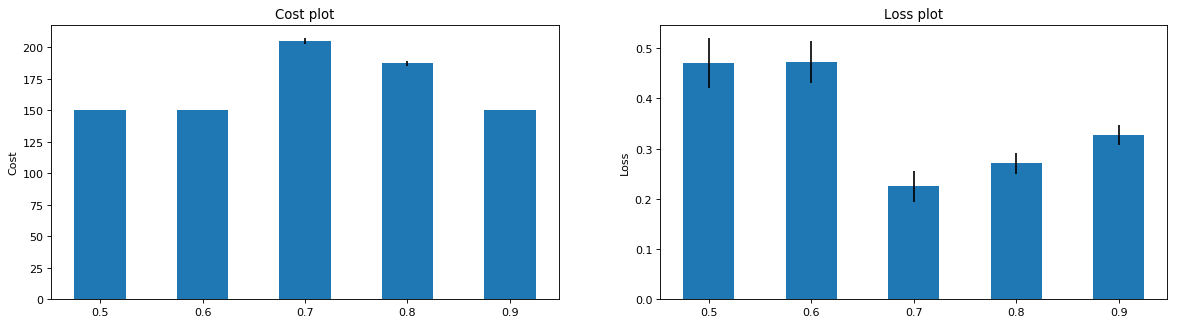

In [127]:
from IPython.core import display as ICD

smv_05 = pd.read_csv('./results/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv')

print_table_columns = ["Threshold", "Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]

print("SmartStop")
ICD.display(pd.DataFrame(smv_05, columns=print_table_columns))


plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
ind = [.5,.6,.7,.8,.9]    # the x locations for the groups
width = 0.05       # the width of the bars: can also be len(x) sequence

cost_mean = smv_05["Cost mean"]
cost_std = smv_05["Cost Std"]

plt.subplot(221)

p1 = plt.bar(ind, cost_mean, width, yerr=cost_std)

plt.ylabel('Cost')
plt.title('Cost plot')


plt.subplot(222)
loss_mean = smv_05["Loss mean"]
loss_std = smv_05["Loss Std"]
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Loss')
plt.title('Loss plot')


plt.show()

**SmartStop approach behaviour using MV. Simulations for balanced data, over different classifications threshold = [.5, .6, .7, .8, .9], with 1000 balanced items, expert cost 20, workers acc mean ≈ 76%, loss ratio = 5.**

### Cost vs loss

***SmartStop approach performance analysis:***

 - We can observe for the classification thresholds .5 and .6 the same behaviour given the percentage obtained by MV when 3 votes are collected. When the 3 votes collected agree MV gives us a 100% probability of being classified as 1 of the 2 classes, either 0 or 1, instead when only 2 votes agree we get a 66,6% chance of classification over one class and this reachs .5 and .6 thresholds acting as the baseline logic. 

 - For threshold .7 we observe that many votes were collected(**1096** more than base) which incremented the quality reducing the loss(and many false negatives) keeping the same precision of lower threshold but incrementing the recall significantly. Comparing the other values we can conclude that this was the better cost-quality performance. 

 - For threshold .8 we can see that more votes have been collected(**738** more than base) but not as many as in the previous, this can be expected due to the bigger difference between the initial item probability of being classified and the threshold(%66,6->%80). The longer this difference is, the more the number of votes will be needed to reach it, and higher is the chance of error. 

 - For threshold .9 no votes were collected and this can be expectable given the big gap between the initial classification probability and threshold(%66,6->%90). We can do further analysis to see this case... **DISCUSS if is needed!!!!**

### Error Rate: penalizing false negatives

We add a loss ratio to penalyze the false negatives which we consiser to be more harmful than the false positives, because are those items which are loss forever. With this table we expect to see the performance of the approaches over different classification thresholds, with a loss ratio = 5, expert cost = 20, over 1000 balanced data, 3 initial votes for MV and SMV.

We set a loss ratio in 5 as we think is a conservative value.

<!---
| Approach      | Threshold | Cost   | Error rate | Error rate lr=10 | Precision | Recall |
|---------------|-----------|--------|------------|------------------|-----------|--------|
| Baseline MV   | .5        | 3000   | 0.156      | 0.874            | 0.845     | 0.842  |
| Brown&Allison | .5        | 2377,44| 0.115      | 0.859            | 0.841     | 0.849  |
| SmartStop MV  | .5        | 3000   | 0.158      | 0.855            | 0.843     | 0.841  |
| SmartStop MV  | .6        | 3000   | 0.157      | 0.852            | 0.843     | 0.843  |
| SmartStop MV  | .7        | 4096,16| 0.115      | 0.353            | 0.842     | 0.947  |
| SmartStop MV  | .8        | 3738   | 0.241      | 0.321            | 0.679     | 0.983  |
| SmartStop MV  | .9        | 3000   | 0.298      | 0.371            | 0.629     | 0.984  |

-->



In [ ]:
print_table_columns = ["Threshold", "Cost mean","Cost Std", "TC mean", "TC std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]
smv_mix = pd.DataFrame({}, columns=print_table_columns)
smv_mix["Loss lr=5"] = []
smv_mix["Name"] = []

smv_mix.loc[0] = [.5, \
             ba_lr1["Cost mean"][0], ba_lr1["Cost Std"][0], \
             ba_lr1["TC mean"][0], ba_lr1["TC std"][0], \
             ba_lr1["Loss mean"][0], ba_lr1["Loss Std"][0], \
             ba_lr1["Recall mean"][0], ba_lr1["Recall Std"][0],\
             ba_lr1["Precision mean"][0], ba_lr1["Precision Std"][0], \
             ba_lr5["Loss mean"][0], "Brown&Allison"]

smv_mix.loc[1] = [.5, \
             mv_base_lr1["Cost mean"][0], mv_base_lr1["Cost Std"][0], \
             mv_base_lr1["TC mean"][0], mv_base_lr1["TC std"][0], \
             mv_base_lr1["Loss mean"][0], mv_base_lr5["Loss Std"][0], \
             mv_base_lr1["Recall mean"][0], mv_base_lr1["Recall Std"][0],\
             mv_base_lr1["Precision mean"][0], mv_base_lr1["Precision Std"][0], \
             mv_base_lr5["Loss mean"][0], "MV Baseline"]

smv_lr1 = pd.read_csv('./results/it50_d50_b5_lr1/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv')
smv_lr5 = pd.read_csv('./results/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv')

idx = 2
for key in range(5):
    smv_mix.loc[idx] = [np.mean([smv_lr1["Threshold"][key], smv_lr5["Threshold"][key]]), \
             np.mean([smv_lr1["Cost mean"][key], smv_lr5["Cost mean"][key]]), \
             np.mean([smv_lr1["Cost Std"][key], smv_lr5["Cost Std"][key]]), \
             np.mean([smv_lr1["TC mean"][key], smv_lr5["TC mean"][key]]), \
             np.mean([smv_lr1["TC std"][key], smv_lr5["TC std"][key]]), \
             smv_lr1["Loss mean"][key], \
             np.mean([smv_lr1["Loss Std"][key], smv_lr5["Loss Std"][key]]), \
             np.mean([smv_lr1["Recall mean"][key], smv_lr5["Recall mean"][key]]), \
             np.mean([smv_lr1["Recall Std"][key], smv_lr5["Recall Std"][key]]),\
             np.mean([smv_lr1["Precision mean"][key], smv_lr5["Precision mean"][key]]), \
             np.mean([smv_lr1["Precision Std"][key], smv_lr5["Precision Std"][key]]), \
             smv_lr5["Loss mean"][key], \
                        "SmartStop MV"]
    
    idx += 1


df = pd.DataFrame(smv_mix, columns=["Name", "Threshold", "Loss mean", "Loss lr=5"])
df.columns = ["Name", "Threshold", "Error rate lr=1", "Error rate lr=5"]
df

### Performance comparison with other approaches

In this case we compare the cost and quality results against the other approaches, we can expect to see an improvement in quality at a reasonable cost when the smart stop module predict to collect more votes. Given the conservative classification criteria, which is to collect votes to ***exclude*** items and if there is not enough evidence ***include*** them, affects the **precision** because the increment in **false positives(FP)**, following a binary classification terminology we can describe them as those items which real value is ***0*** and are classified as ***1***.

MV Baseline


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.0,0.0,0.472,0.045,0.843,0.017,0.843,0.017


Brown&Allison 2-1 Break Tie


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,118.713,0.736,0.454,0.04,0.849,0.016,0.848,0.015


SmartStop


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.000,0.000,0.471,0.050,0.843,0.019,0.842,0.014
1,0.6,150.000,0.000,0.472,0.042,0.842,0.016,0.847,0.013
2,0.7,205.180,2.322,0.225,0.031,0.946,0.012,0.840,0.016
3,0.8,187.088,1.816,0.271,0.021,0.984,0.007,0.680,0.013
4,0.9,150.000,0.000,0.327,0.020,0.985,0.006,0.631,0.009


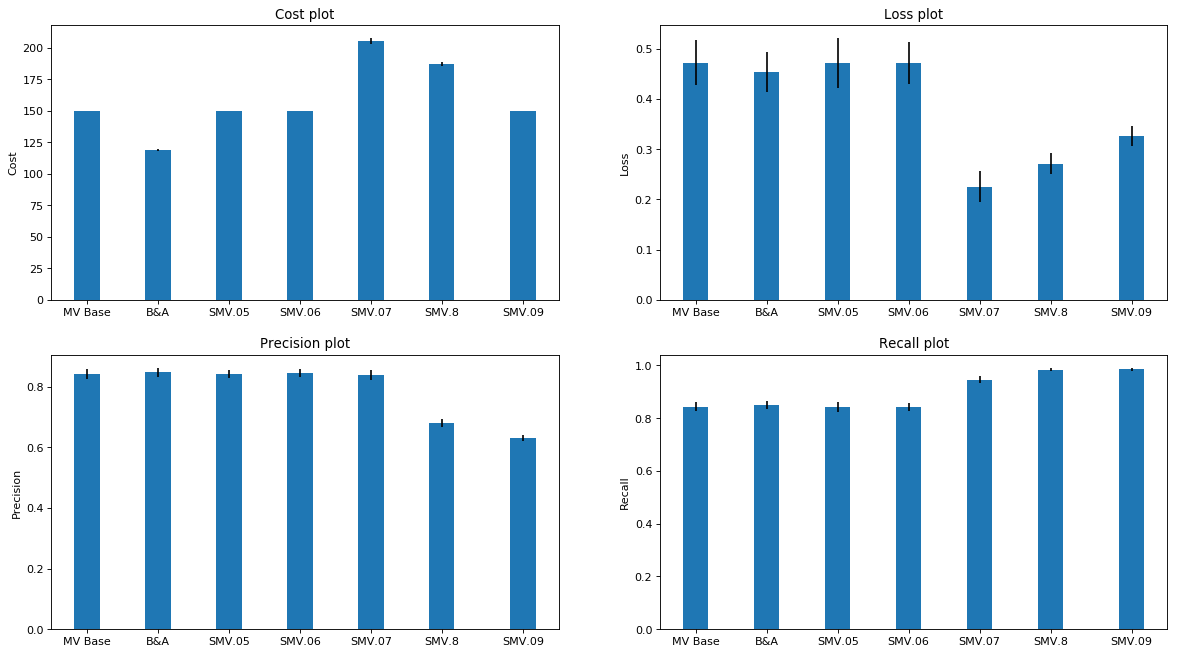

In [123]:
from IPython.core import display as ICD

mv_base_01 = pd.read_csv('./results/it50_d50_b5_lr5/baseline_mv_it50_b5_v3_cr05.csv')
ba_01 = pd.read_csv('./results/it50_d50_b5_lr5/mv_break_tie_it50_b5_cr05.csv')
smv_01 = pd.read_csv('./results/it50_d50_b5_lr5/smart_stop_mv_not_expert_it50_d50_b5_cr05.csv')

print_table_columns = ["Threshold", "Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]

print("MV Baseline")
ICD.display(pd.DataFrame(mv_base_01, columns=print_table_columns))

print("Brown&Allison 2-1 Break Tie")
ICD.display(pd.DataFrame(ba_01, columns=print_table_columns))

print("SmartStop")
ICD.display(pd.DataFrame(smv_01, columns=print_table_columns))

#plot
datasets = [mv_base_01, ba_01, smv_01]

def get_approaches_results(datasets, column_mean, column_std):
    mean = []
    std = []
    #initial
    mean.append(datasets[0][column_mean][0])
    std.append(datasets[0][column_std][0])
    mean.append(datasets[1][column_mean][0])
    std.append(datasets[1][column_std][0])

    i = 0
    for _ in range(5):
        mean.append(datasets[2][column_mean][i])
        std.append(datasets[2][column_std][i])
        i += 1
        
    return mean, std

plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
ind = [.14, .28, .42, .56, .70 , .84, 1]    # the x locations for the groups
width = 0.05       # the width of the bars: can also be len(x) sequence

cost_mean, cost_std = get_approaches_results(datasets, "Cost mean", "Cost Std")

plt.subplot(221)

p1 = plt.bar(ind, cost_mean, width, yerr=cost_std)

plt.ylabel('Cost')
plt.title('Cost plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(222)
loss_mean, loss_std = get_approaches_results(datasets, "Loss mean", "Loss Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Loss')
plt.title('Loss plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(223)
loss_mean, loss_std = get_approaches_results(datasets, "Precision mean", "Precision Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Precision')
plt.title('Precision plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(224)
loss_mean, loss_std = get_approaches_results(datasets, "Recall mean", "Recall Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Recall')
plt.title('Recall plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))

plt.show()


**Behaviour of the approaches. Simulations for unbalanced data 10% possitives, over different classifications threshold = [.5, .6, .7, .8, .9], with 1000 balanced items, expert cost 20, workers acc mean ≈ 76%, loss ratio = 5.**

As expected the quality was higher when using the module predictions, reducing the loss and incrementing the recall, as an effect of the classification criteria the precision is reduced. In the case of threshold .9 the recall is high because it reduces the false negative amount due to it strictness, but it has a big impact in precision becoming this case the worse one in terms of number of false positives.

## 3.3.2) Experiments with unbalanced data

At this point we are interested in analyzing the cost-quality performance of the approaches over unbalanced data.

In [ ]:
iterations_per_ct = 50
drawing_simulations_amount = 50
data_true_percentage = .5
b_str = str(round(data_true_percentage-int(data_true_percentage), 2))[2:]
lr = 5
folder_name = f'it{iterations_per_ct}_d{drawing_simulations_amount}_b{b_str}_lr{lr}'

crs = [1/10, 1/50, 1/100, 1/500] # .1, .02, .01, .002

for cr in crs:
    cts = [.5, .6, .7 , .8 , .9]
     
    cr = round(cr,2)
    cr_str = str(round(cr-int(cr), 2))[2:]  
    
    #SMV
    results_smv = run_experiment_1()
    pd.DataFrame(results_smv, columns=pdColumns) \
    .to_csv(f'results/{folder_name}/smart_stop_mv_not_expert_it{iterations_per_ct}_d{drawing_simulations_amount}_b{b_str}_cr{cr_str}.csv', index=False)

'''
cts = [.5]

#mv baseline
results_baseline = run_experiment_2()
pd.DataFrame(results_baseline, columns=pdColumns) \
    .to_csv(f'results/{folder_name}/baseline_mv_it{iterations_per_ct}_b{b_str}_v{base_votes_per_item}_cr{cr_str}.csv', index=False)

#break tie
results_b_a = run_experiment_3()
pd.DataFrame(results_b_a, columns=pdColumns) \
    .to_csv(f'results/{folder_name}/mv_break_tie_it{iterations_per_ct}_b{b_str}_cr{cr_str}.csv', index=False)
'''
    

  0%|          | 0/5 [00:00<?, ?it/s]

Running Experiment 1: Smart Stop majority_voting

        Hyparparameters:
            - Classification
                * Classification function: majority_voting
                * Cost ratio: 0.1
            - Classification thresholds:
                * [0.5, 0.6, 0.7, 0.8, 0.9]
            - Items
                * Amount: 1000 
                * Ground true percentage: 0.5
            - MV votes:
                * Base votes per item: 3
            - Workers
                * Amount of workers: 1000
                * Cheaters percentage: 0
                * If not fixed, workers accuracy > 0.5 
                * Workers fixed accuracy? False
                * Fixed number: 0.9
            - Cost estimator fn
                * Cost estimator drawing number: 50
                * Expert cost increment: 2
            - Experiments convergence:
                * # iterations per classification threshold: 50
            - Penalization in false negatives
                * k: 5
    


  0%|          | 0/5 [00:00<?, ?it/s]

Running Experiment 1: Smart Stop majority_voting

        Hyparparameters:
            - Classification
                * Classification function: majority_voting
                * Cost ratio: 0.02
            - Classification thresholds:
                * [0.5, 0.6, 0.7, 0.8, 0.9]
            - Items
                * Amount: 1000 
                * Ground true percentage: 0.5
            - MV votes:
                * Base votes per item: 3
            - Workers
                * Amount of workers: 1000
                * Cheaters percentage: 0
                * If not fixed, workers accuracy > 0.5 
                * Workers fixed accuracy? False
                * Fixed number: 0.9
            - Cost estimator fn
                * Cost estimator drawing number: 50
                * Expert cost increment: 2
            - Experiments convergence:
                * # iterations per classification threshold: 50
            - Penalization in false negatives
                * k: 5
    


  0%|          | 0/5 [00:00<?, ?it/s]

Running Experiment 1: Smart Stop majority_voting

        Hyparparameters:
            - Classification
                * Classification function: majority_voting
                * Cost ratio: 0.01
            - Classification thresholds:
                * [0.5, 0.6, 0.7, 0.8, 0.9]
            - Items
                * Amount: 1000 
                * Ground true percentage: 0.5
            - MV votes:
                * Base votes per item: 3
            - Workers
                * Amount of workers: 1000
                * Cheaters percentage: 0
                * If not fixed, workers accuracy > 0.5 
                * Workers fixed accuracy? False
                * Fixed number: 0.9
            - Cost estimator fn
                * Cost estimator drawing number: 50
                * Expert cost increment: 2
            - Experiments convergence:
                * # iterations per classification threshold: 50
            - Penalization in false negatives
                * k: 5
    


 80%|████████  | 4/5 [4:52:38<1:18:11, 4691.62s/it]

### Results for unbalanced data 10% positives - 90% negatives

MV Baseline


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.0,0.0,0.22,0.023,0.841,0.036,0.375,0.024


Brown&Allison 2-1 Break Tie


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,118.69,0.85,0.222,0.023,0.837,0.038,0.374,0.023


SmartStop


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.000,0.000,0.219,0.019,0.844,0.032,0.375,0.021
1,0.6,150.000,0.000,0.220,0.022,0.839,0.036,0.376,0.021
2,0.7,205.078,2.647,0.183,0.016,0.950,0.023,0.376,0.018
3,0.8,186.793,1.526,0.427,0.020,0.985,0.012,0.190,0.007
4,0.9,150.000,0.000,0.530,0.016,0.982,0.013,0.159,0.004


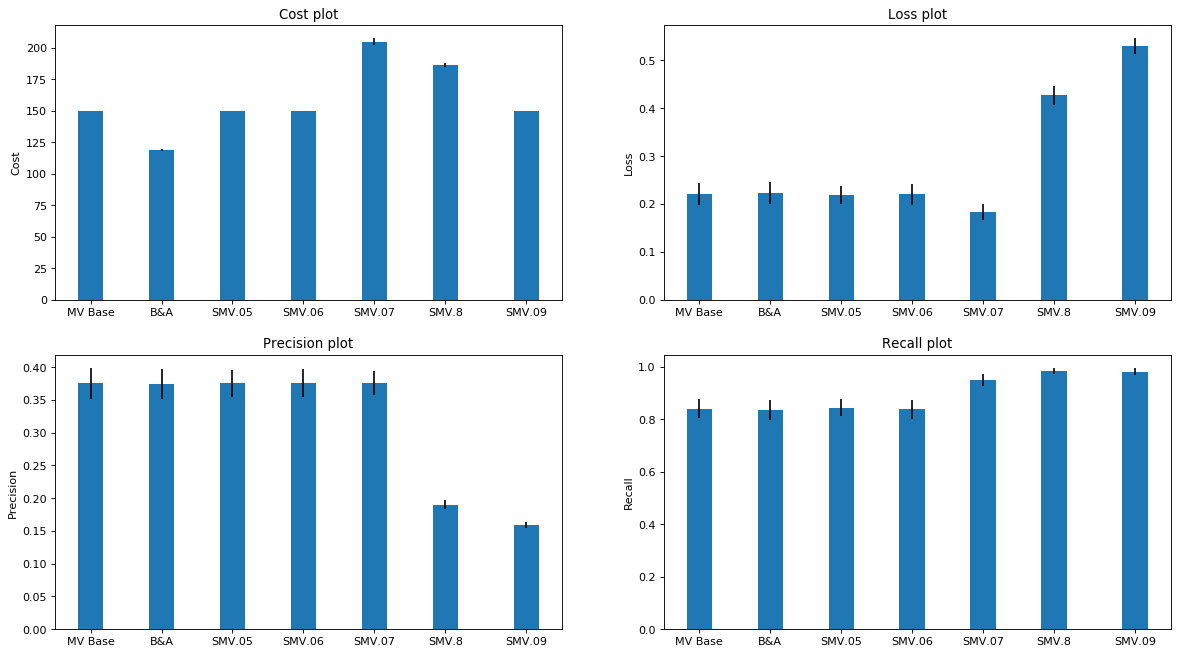

In [125]:
from IPython.core import display as ICD

mv_base_01 = pd.read_csv('./results/it50_d50_b1_lr5/baseline_mv_it50_b1_v3_cr05.csv')
ba_01 = pd.read_csv('./results/it50_d50_b1_lr5/mv_break_tie_it50_b1_cr05.csv')
smv_01 = pd.read_csv('./results/it50_d50_b1_lr5/smart_stop_mv_not_expert_it50_d50_b1_cr05.csv')

print_table_columns = ["Threshold", "Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]

print("MV Baseline")
ICD.display(pd.DataFrame(mv_base_01, columns=print_table_columns))

print("Brown&Allison 2-1 Break Tie")
ICD.display(pd.DataFrame(ba_01, columns=print_table_columns))

print("SmartStop")
ICD.display(pd.DataFrame(smv_01, columns=print_table_columns))

#plot
datasets = [mv_base_01, ba_01, smv_01]

def get_approaches_results(datasets, column_mean, column_std):
    mean = []
    std = []
    #initial
    mean.append(datasets[0][column_mean][0])
    std.append(datasets[0][column_std][0])
    mean.append(datasets[1][column_mean][0])
    std.append(datasets[1][column_std][0])

    i = 0
    for _ in range(5):
        mean.append(datasets[2][column_mean][i])
        std.append(datasets[2][column_std][i])
        i += 1
        
    return mean, std

plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
ind = [.14, .28, .42, .56, .70 , .84, 1]    # the x locations for the groups
width = 0.05       # the width of the bars: can also be len(x) sequence

cost_mean, cost_std = get_approaches_results(datasets, "Cost mean", "Cost Std")

plt.subplot(221)

p1 = plt.bar(ind, cost_mean, width, yerr=cost_std)

plt.ylabel('Cost')
plt.title('Cost plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(222)
loss_mean, loss_std = get_approaches_results(datasets, "Loss mean", "Loss Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Loss')
plt.title('Loss plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(223)
loss_mean, loss_std = get_approaches_results(datasets, "Precision mean", "Precision Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Precision')
plt.title('Precision plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(224)
loss_mean, loss_std = get_approaches_results(datasets, "Recall mean", "Recall Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Recall')
plt.title('Recall plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.show()


**Behaviour of the approaches. Simulations for unbalanced data 10% possitives, over different classifications threshold = [.5, .6, .7, .8, .9], with 1000 balanced items, expert cost 20, workers acc mean ≈ 76%, loss ratio = 5.**

We can get similar conclusion with unbalanced data, the threshold .7 continue having the better performance in terms of cost-quality. In particular the bigger thresholds(.8 and .9) are affected significantly in this case compared to balanced dataset, again the reason is the impact of false positives that in this case are more likely to appear.

### 3.3.3) Results for unbalanced data 1% positives - 99% negatives

MV Baseline


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.0,0.0,0.161,0.013,0.85,0.115,0.053,0.008


Brown&Allison 2-1 Break Tie


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,118.697,0.766,0.164,0.013,0.852,0.102,0.052,0.007


SmartStop


,Threshold,Cost mean,Cost Std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,150.000,0.000,0.162,0.013,0.862,0.120,0.053,0.008
1,0.6,150.000,0.000,0.166,0.017,0.844,0.134,0.051,0.010
2,0.7,204.914,2.273,0.177,0.013,0.958,0.064,0.052,0.005
3,0.8,187.348,1.610,0.463,0.018,0.970,0.050,0.021,0.001
4,0.9,150.000,0.000,0.575,0.015,0.980,0.040,0.017,0.001


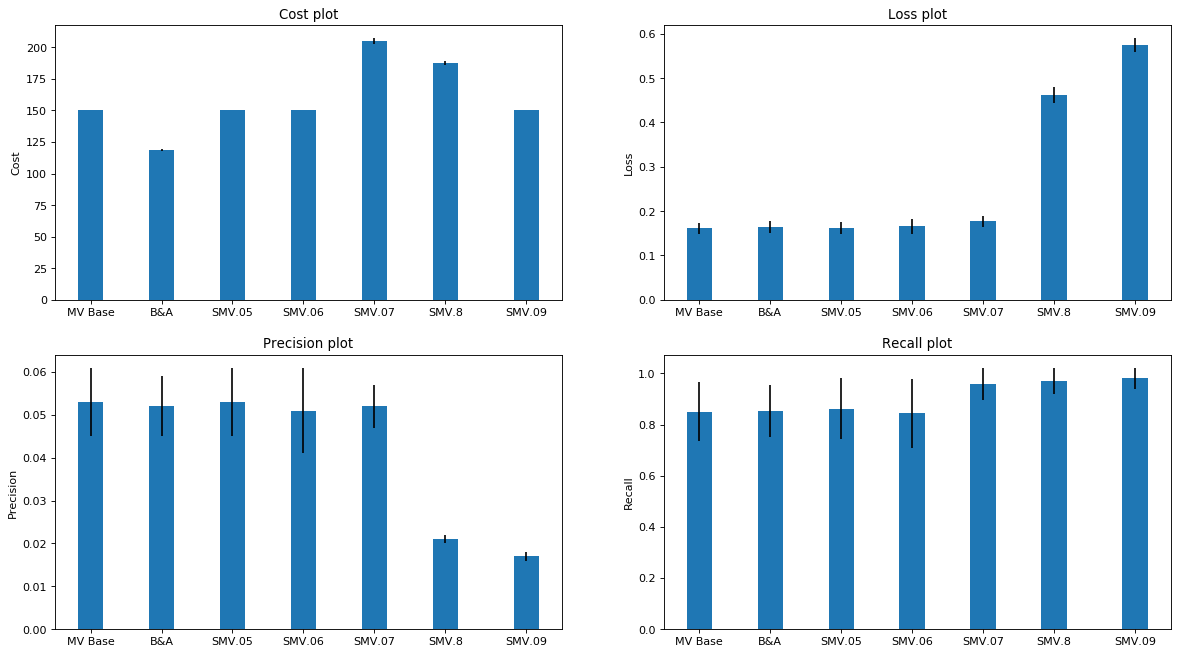

In [126]:
from IPython.core import display as ICD

mv_base_01 = pd.read_csv('./results/it50_d50_b01_lr5/baseline_mv_it50_b01_v3_cr05.csv')
ba_01 = pd.read_csv('./results/it50_d50_b01_lr5/mv_break_tie_it50_b01_cr05.csv')
smv_01 = pd.read_csv('./results/it50_d50_b01_lr5/smart_stop_mv_not_expert_it50_d50_b01_cr05.csv')

print_table_columns = ["Threshold", "Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]

print("MV Baseline")
ICD.display(pd.DataFrame(mv_base_01, columns=print_table_columns))

print("Brown&Allison 2-1 Break Tie")
ICD.display(pd.DataFrame(ba_01, columns=print_table_columns))

print("SmartStop")
ICD.display(pd.DataFrame(smv_01, columns=print_table_columns))

#plot
datasets = [mv_base_01, ba_01, smv_01]

def get_approaches_results(datasets, column_mean, column_std):
    mean = []
    std = []
    #initial
    mean.append(datasets[0][column_mean][0])
    std.append(datasets[0][column_std][0])
    mean.append(datasets[1][column_mean][0])
    std.append(datasets[1][column_std][0])

    i = 0
    for _ in range(5):
        mean.append(datasets[2][column_mean][i])
        std.append(datasets[2][column_std][i])
        i += 1
        
    return mean, std

plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
ind = [.14, .28, .42, .56, .70 , .84, 1]    # the x locations for the groups
width = 0.05       # the width of the bars: can also be len(x) sequence

cost_mean, cost_std = get_approaches_results(datasets, "Cost mean", "Cost Std")

plt.subplot(221)

p1 = plt.bar(ind, cost_mean, width, yerr=cost_std)

plt.ylabel('Cost')
plt.title('Cost plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(222)
loss_mean, loss_std = get_approaches_results(datasets, "Loss mean", "Loss Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Loss')
plt.title('Loss plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(223)
loss_mean, loss_std = get_approaches_results(datasets, "Precision mean", "Precision Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Precision')
plt.title('Precision plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))


plt.subplot(224)
loss_mean, loss_std = get_approaches_results(datasets, "Recall mean", "Recall Std")
p2 = plt.bar(ind, loss_mean, width, yerr=loss_std)
plt.ylabel('Recall')
plt.title('Recall plot')
plt.xticks(ind, ('MV Base', 'B&A', 'SMV.05', 'SMV.06', 'SMV.07', 'SMV.8', 'SMV.09'))

plt.show()


**Behaviour of the approaches. Simulations for unbalanced data 1% possitives, over different classifications threshold = [.5, .6, .7, .8, .9], with 1000 balanced items, expert cost 20, workers acc mean ≈ 76%, loss ratio = 5.**

This case is similar to the previous one, with the difference of having a bigger difference in precision values of thresholds .8 and .9, and as expected a directly related loss increment.

## 4) Next step: Experiments estimating workers accuracy

In [15]:
#alg_utils.print_hyperparameters(cf, cr,base_votes_per_item, drawing_simulations_amount, expert_cost_increment, workers_num, z, fixed_acc, base_workers_acc, fixed_workers_acc, items_num, data_true_percentage, iterations_per_ct, cts)
#results_truth_finder = run_experiment_1()

#table    
#pd.DataFrame(results_truth_finder, columns=pdColumns).to_csv('results/smart_stop_truth_finder_not_expert.csv', index=False)
#pd.DataFrame(results_truth_finder, columns=pdColumns)